# Import Library

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
from sklearn.ensemble import VotingRegressor, ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import catboost as cb
from lightgbm import LGBMRegressor

from optuna.samplers import TPESampler
import optuna

from lazypredict.Supervised import LazyRegressor

# High level configuration

In [66]:
SEED = 42

## Cross Validation Function

In [67]:
class Trainer:
    def __init__(self, model, n_folds=10):
        self.model = model
        self.n_folds = n_folds

    def fit(self, X, y):
        print(f'Training {self.model.__class__.__name__}')

        kf = KFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        
        r2s = []
        mses = []
        oof_pred = np.zeros(len(X))

        for fold, (train_index, valid_index) in enumerate(kf.split(X)):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

            model = clone(self.model)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_valid)
            oof_pred[valid_index] = y_pred

            r2 = r2_score(y_valid, y_pred)
            mse = mean_squared_error(y_valid, y_pred)
            r2s.append(r2)
            mses.append(mse)

            print(f'--- Fold {fold + 1} - R2: {r2:.6f} - MSE: {mse:.6f}')

        print(f'\n----- MSE: {np.mean(mses):.6f} ± {np.std(mses):.6f}')
        print(f'----- R2: {np.mean(r2s):.6f} ± {np.std(r2s):.6f}\n\n')

        return oof_pred, r2s, mses

    def fit_predict(self, X, y, X_test):
        model = clone(self.model)
        model.fit(X, y)
        return model.predict(X_test)


# Explanatory Data Analysis

In [68]:
df_train = pd.read_csv('./train.csv', index_col=0)
df_test = pd.read_csv('./test.csv', index_col=0)

## Data Understanding

In [69]:
df_train.shape, df_test.shape

((8000, 18), (2000, 17))

In [70]:
df_train.head()

,city_name,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index,city_development_index
data_id,,,,,,,,,,,,,,,,,,
C1_2014,Aba,NGA,2014-2015,918263,55.93,69.44,48.15,88.33,55.74,8,70.94,56,41.11,55.64,65.10,49.82,52.02,59.63
C2_2014,Abidjan,CIV,2014-2015,4410752,50.53,45.58,66.18,54.25,43.97,7,62.11,63,45.52,57.53,59.60,60.71,50.24,54.57
C3_2014,Abobo,CIV,2014-2015,822165,55.61,67.28,47.98,45.74,49.30,7,69.85,58,47.67,40.87,55.01,55.78,47.87,52.74
C4_2014,Abomey Calavi,BEN,2014-2015,708578,60.12,48.04,51.90,41.53,68.39,10,60.11,51,51.86,54.92,67.21,41.42,57.55,54.29
C5_2014,Abu Dhabi,ARE,2014-2015,1138076,76.02,75.86,61.68,67.35,82.71,12,83.28,73,62.08,74.39,71.63,74.15,52.22,70.54


In [71]:
df_test.head()

,city_name,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index
data_id,,,,,,,,,,,,,,,,,
C801_2014,Shimkent,KAZ,2014-2015,797426,62.30,20.91,39.79,59.09,64.08,10,73.96,59,48.85,34.05,47.69,63.81,44.19
C802_2014,Shiraz,IRN,2014-2015,1517029,62.39,40.33,42.92,57.18,50.35,8,64.76,55,72.05,57.08,61.20,58.10,54.69
C803_2014,Shiyan,CHN,2014-2015,1015370,57.58,69.05,51.25,64.45,58.25,9,55.68,54,58.80,70.04,53.67,54.78,54.10
C804_2014,Shizuoka,JPN,2014-2015,2816484,48.56,55.00,49.30,50.70,37.55,6,66.28,55,41.84,29.83,65.40,49.25,55.72
C805_2014,Sialkot,PAK,2014-2015,615115,64.41,40.30,51.19,46.80,48.89,7,67.00,60,77.35,55.52,48.92,60.54,50.79


### Handle data anomaly
When we check the overview of the dataset on the kaggle, we saw the `train.csv` has proportional unique value `data_id` and `city_name`,
whereas the `test.csv` has 2000 unique `data_id` and 197 unique `city_name`. 

It really intrigue our curiosity :D

In [72]:
df_train['city_name'].value_counts()

city_name
Aba               10
Maiduguri         10
Lusaka            10
Luxembourg        10
Luxor             10
                  ..
Erbil             10
Erduosi Ordoss    10
Esfahan           10
Eskisehir         10
Shijiazhuang      10
Name: count, Length: 800, dtype: int64

In [73]:
df_test['city_name'].value_counts()

city_name
Valencia    20
Suzhou      20
Taizhou     20
Xiamen      10
Winnipeg    10
            ..
Tianjin     10
Tianmen     10
Tianshui    10
Tijuana     10
Zurich      10
Name: count, Length: 197, dtype: int64

In [74]:
df_test[df_test['city_name'] == 'Valencia'].head()

,city_name,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index
data_id,,,,,,,,,,,,,,,,,
C902_2014,Valencia,VEN,2014-2015,1947666,56.00,53.17,50.53,45.44,44.40,7,60.56,53,63.03,56.05,62.21,46.60,62.74
C903_2014,Valencia,ESP,2014-2015,806968,69.45,45.46,34.21,45.47,57.89,9,71.36,57,79.09,68.47,61.10,66.09,40.16
C902_2015,Valencia,VEN,2015-2016,1986946,55.31,53.65,51.15,45.17,44.94,7,60.21,52,60.78,55.48,61.92,45.27,61.34
C903_2015,Valencia,ESP,2015-2016,812636,69.51,46.64,33.36,44.58,58.25,9,69.70,55,80.58,66.51,60.64,63.03,37.65
C902_2016,Valencia,VEN,2016-2017,2027018,53.79,50.00,51.26,44.87,45.24,7,57.55,51,58.59,52.59,61.26,45.29,60.42


In [75]:
df_test[df_test['city_name'] == 'Suzhou'].head()

,city_name,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index
data_id,,,,,,,,,,,,,,,,,
C830_2014,Suzhou,CHN,2014-2015,5038887,60.39,56.40,29.51,46.10,55.21,8,73.88,51,52.08,61.55,71.02,49.88,45.30
C831_2014,Suzhou,CHN,2014-2015,5038887,58.01,61.81,71.74,73.67,63.96,10,65.76,67,44.31,47.08,59.49,63.03,46.69
C830_2015,Suzhou,CHN,2015-2016,5336392,58.51,55.01,31.91,45.90,53.20,8,71.95,50,50.38,63.91,70.09,47.13,44.11
C831_2015,Suzhou,CHN,2015-2016,5336392,58.75,63.60,72.01,73.47,65.97,10,67.51,67,42.78,47.66,57.03,61.76,48.87
C830_2016,Suzhou,CHN,2016-2017,5651909,57.46,56.39,33.40,45.34,50.04,8,70.34,51,52.00,64.10,69.44,48.98,43.59


In [76]:
df_test[df_test['city_name'] == 'Taizhou'].head()

,city_name,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index
data_id,,,,,,,,,,,,,,,,,
C845_2014,Taizhou,CHN,2014-2015,1209415,55.54,73.51,55.57,65.54,54.14,8,49.34,50,63.14,54.15,57.51,44.38,41.62
C846_2014,Taizhou,CHN,2014-2015,1157007,66.86,60.63,39.31,62.02,62.31,9,75.32,54,62.96,47.90,56.03,46.88,68.06
C845_2015,Taizhou,CHN,2015-2016,1227516,55.97,73.16,54.23,65.04,54.87,8,47.46,49,65.57,53.12,54.37,45.71,42.37
C846_2015,Taizhou,CHN,2015-2016,1186960,66.08,57.74,40.11,61.63,59.74,9,74.54,53,63.96,49.09,55.06,45.72,67.48
C845_2016,Taizhou,CHN,2016-2017,1245915,56.64,68.75,52.08,65.07,55.67,8,47.24,49,67.00,54.79,53.41,47.32,42.25


Turns out: 
- Valencia is on 2 country such as VEN, ESP 
- Suzhou is on the same country (CHN) and with the same population only (not with hdi, mobility, air_quality, etc.)
- Taizhou is on the same country (CHN) but it has different data

We conclude that we can't rely on city_name thus, we are planning to drop it later and extract the city id from data_id

### Combine the `df_train` with `df_test`

We do this so we can get better result on imputation / normalization

In [77]:
df_combined = pd.concat([df_train, df_test])
df_combined.shape

(10000, 18)

In [78]:
df_combined.drop(columns='city_name', inplace=True)
df_combined.head()

,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index,city_development_index
data_id,,,,,,,,,,,,,,,,,
C1_2014,NGA,2014-2015,918263,55.93,69.44,48.15,88.33,55.74,8,70.94,56,41.11,55.64,65.10,49.82,52.02,59.63
C2_2014,CIV,2014-2015,4410752,50.53,45.58,66.18,54.25,43.97,7,62.11,63,45.52,57.53,59.60,60.71,50.24,54.57
C3_2014,CIV,2014-2015,822165,55.61,67.28,47.98,45.74,49.30,7,69.85,58,47.67,40.87,55.01,55.78,47.87,52.74
C4_2014,BEN,2014-2015,708578,60.12,48.04,51.90,41.53,68.39,10,60.11,51,51.86,54.92,67.21,41.42,57.55,54.29
C5_2014,ARE,2014-2015,1138076,76.02,75.86,61.68,67.35,82.71,12,83.28,73,62.08,74.39,71.63,74.15,52.22,70.54


### Descriptive analysis

In [79]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, C1_2014 to C1000_2023
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country_id                10000 non-null  object 
 1   year                      10000 non-null  object 
 2   population                10000 non-null  int64  
 3   human_development_index   10000 non-null  float64
 4   mobility_index            10000 non-null  float64
 5   air_quality_index         10000 non-null  float64
 6   energy_consumption_index  10000 non-null  float64
 7   education_index           10000 non-null  float64
 8   school_life_expectancy    10000 non-null  int64  
 9   healthcare_index          10000 non-null  float64
 10  life_expectancy           10000 non-null  int64  
 11  income_inequality_index   9990 non-null   float64
 12  employment_rate           10000 non-null  float64
 13  governance_index          10000 non-null  float64
 14  

In [18]:
df_combined.describe().T

,count,mean,std,min,25%,50%,75%,max
population,10000.00,2110351.14,3330714.47,967.00,745443.25,1074977.50,1982556.75,37435191.00
human_development_index,10000.00,56.22,7.63,19.03,51.35,55.81,60.87,149.17
mobility_index,10000.00,49.34,9.86,13.36,43.25,49.44,55.69,87.37
air_quality_index,10000.00,45.96,11.83,4.41,38.08,46.17,53.70,88.49
energy_consumption_index,10000.00,50.88,11.33,2.08,44.91,51.60,58.23,88.33
education_index,10000.00,53.43,12.17,6.05,45.34,52.95,61.13,93.07
school_life_expectancy,10000.00,8.01,1.85,1.00,7.00,8.00,9.00,14.00
healthcare_index,10000.00,58.14,9.04,21.30,52.28,57.64,63.36,305.73
life_expectancy,10000.00,51.83,7.14,20.00,48.00,52.00,56.00,137.00
income_inequality_index,9990.00,57.08,13.92,10.26,47.61,57.13,67.07,100.00


### Another data anomaly
Index should be only from 0 - 100, we think something went wrong and need a further investigation

In [19]:
df_combined[(df_combined['human_development_index'] > 100) | (df_combined['healthcare_index'] > 100) | (df_combined['life_expectancy'] > 85)]

,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index,city_development_index
data_id,,,,,,,,,,,,,,,,,
C350_2023,VNM,2023-2024,9320866,149.17,39.20,34.00,49.09,80.20,12,305.73,137,61.57,80.60,60.40,71.70,76.48,85.90


data_id `C350_2023` is broken it has `human_development_index` of 149.17, `healthcare_index` of 305.73,
and `life_expectancy` of 137. So we are going to drop that

In [20]:
df_combined = df_combined.drop(index='C350_2023')

In [21]:
df_combined

,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index,city_development_index
data_id,,,,,,,,,,,,,,,,,
C1_2014,NGA,2014-2015,918263,55.93,69.44,48.15,88.33,55.74,8,70.94,56,41.11,55.64,65.10,49.82,52.02,59.63
C2_2014,CIV,2014-2015,4410752,50.53,45.58,66.18,54.25,43.97,7,62.11,63,45.52,57.53,59.60,60.71,50.24,54.57
C3_2014,CIV,2014-2015,822165,55.61,67.28,47.98,45.74,49.30,7,69.85,58,47.67,40.87,55.01,55.78,47.87,52.74
C4_2014,BEN,2014-2015,708578,60.12,48.04,51.90,41.53,68.39,10,60.11,51,51.86,54.92,67.21,41.42,57.55,54.29
C5_2014,ARE,2014-2015,1138076,76.02,75.86,61.68,67.35,82.71,12,83.28,73,62.08,74.39,71.63,74.15,52.22,70.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C996_2023,CHN,2023-2024,1254519,59.62,54.95,40.34,50.66,56.60,8,51.17,45,71.10,47.25,55.61,44.66,52.11,NaN
C997_2023,CHN,2023-2024,2780142,67.28,43.82,47.36,58.30,60.48,9,58.71,53,82.64,39.68,49.06,52.46,44.03,NaN
C998_2023,CHN,2023-2024,768075,53.37,49.44,27.75,64.52,51.98,8,58.04,52,50.08,61.93,50.65,69.34,47.68,NaN


In [22]:
df_combined.describe().T

,count,mean,std,min,25%,50%,75%,max
population,9999.00,2109630.01,3330100.26,967.00,745419.50,1074933.00,1982203.00,37435191.00
human_development_index,9999.00,56.21,7.57,19.03,51.35,55.81,60.86,85.01
mobility_index,9999.00,49.35,9.86,13.36,43.25,49.44,55.69,87.37
air_quality_index,9999.00,45.96,11.83,4.41,38.08,46.18,53.70,88.49
energy_consumption_index,9999.00,50.88,11.33,2.08,44.91,51.60,58.23,88.33
education_index,9999.00,53.43,12.16,6.05,45.34,52.94,61.13,93.07
school_life_expectancy,9999.00,8.01,1.85,1.00,7.00,8.00,9.00,14.00
healthcare_index,9999.00,58.12,8.69,21.30,52.28,57.64,63.36,92.30
life_expectancy,9999.00,51.82,7.09,20.00,48.00,52.00,56.00,85.00
income_inequality_index,9989.00,57.08,13.92,10.26,47.61,57.13,67.07,100.00


### city_id and year extraction
while looking on the index we can see that it consist of 2 parts that seperated by `_`

In [23]:
df_combined['city_id'] = df_combined.index.str.split('_').str[0]
df_combined['new_year'] = df_combined.index.str.split('_').str[1]
df_combined['city_id'] = df_combined['city_id'].astype('category')
df_combined['year'] = df_combined['new_year']
df_combined.drop(columns=['new_year'], inplace=True)
df_combined.head()

,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index,city_development_index,city_id
data_id,,,,,,,,,,,,,,,,,,
C1_2014,NGA,2014,918263,55.93,69.44,48.15,88.33,55.74,8,70.94,56,41.11,55.64,65.10,49.82,52.02,59.63,C1
C2_2014,CIV,2014,4410752,50.53,45.58,66.18,54.25,43.97,7,62.11,63,45.52,57.53,59.60,60.71,50.24,54.57,C2
C3_2014,CIV,2014,822165,55.61,67.28,47.98,45.74,49.30,7,69.85,58,47.67,40.87,55.01,55.78,47.87,52.74,C3
C4_2014,BEN,2014,708578,60.12,48.04,51.90,41.53,68.39,10,60.11,51,51.86,54.92,67.21,41.42,57.55,54.29,C4
C5_2014,ARE,2014,1138076,76.02,75.86,61.68,67.35,82.71,12,83.28,73,62.08,74.39,71.63,74.15,52.22,70.54,C5


In [24]:
print(len(df_combined))
print(len(df_combined['city_id'].unique()))

9999
1000


By extracting the city based on data_id now we get proportionate unique city

In [25]:
def plot_over_the_year(column_name, title_name, df=df_combined, adjust_top=0.97):
    # g = sns.FacetGrid(data=df, col='country_id', col_wrap=6, height=3, sharey=False, sharex=['col'])
    # g.map(sns.pointplot, 'year', column_name, order=df_combined['year'].unique().tolist(), errorbar=None)
    # g.set_xticklabels(['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'])
    # plt.subplots_adjust(hspace=0.4)
    # for ax in g.axes.flat:
    #     for label in ax.get_xticklabels():
    #         label.set_rotation(45)
    # g.fig.subplots_adjust(top=adjust_top)
    # g.fig.suptitle(f'{title_name} over the year')
    # plt.show()
    pass

In [26]:
plot_over_the_year('city_development_index', 'City Development Index')

Based on our finding, we found that some countries doesn't have a value on the train dataset which we need to put a consideration
when including `city_id` on our model

some workaround, can be adding another data such as the continent or area

In [27]:
missing_country_id_in_train = ['SGP', 'EST', 'UZB', 'GEO', 'TUN', 'MNG', 'AUT',
                               'LTU', 'ARM', 'HRV'
                               ]

We gonna check and do analysis for the missing country (on train data) to check if all of them has same pattern
(for the correlation bigger than 0.5)

In [28]:
plot_over_the_year('population', 'Population', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [29]:
plot_over_the_year('human_development_index', 'HDI', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [30]:
plot_over_the_year('mobility_index', 'Mobility Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [31]:
plot_over_the_year('air_quality_index', 'Air Quality Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [32]:
plot_over_the_year('energy_consumption_index', 'Energy Consumption Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [33]:
plot_over_the_year('education_index', 'Education Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [34]:
plot_over_the_year('school_life_expectancy', 'School Life Expectancy', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [35]:
plot_over_the_year('healthcare_index', 'Healthcare Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [36]:
plot_over_the_year('life_expectancy', 'Life Expectancy', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [37]:
plot_over_the_year('income_inequality_index', 'Income Inequality Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [38]:
plot_over_the_year('employment_rate', 'Employment Rate', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [39]:
plot_over_the_year('governance_index', 'Governance Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [40]:
plot_over_the_year('safety_index', 'Safety Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [41]:
plot_over_the_year('internet_quality_index', 'Internet Quality Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

In [42]:
plot_over_the_year('internet_quality_index', 'Internet Quality Index', df_combined[df_combined['country_id'].isin(missing_country_id_in_train)], adjust_top=0.87)

### Validate that all city on the test data does not appear on the training data

In [43]:
missing_city_id_in_train = []
city_id_train = df_combined[df_combined['city_development_index'].notnull()]['city_id'].to_list()
city_id_test = df_combined[df_combined['city_development_index'].isnull()]['city_id'].to_list()

for city in city_id_test:
    if city not in city_id_train:
        missing_city_id_in_train.append(city)
        
print(missing_city_id_in_train)
print("total missing entries:", len(missing_city_id_in_train))

['C801', 'C802', 'C803', 'C804', 'C805', 'C806', 'C807', 'C808', 'C809', 'C810', 'C811', 'C812', 'C813', 'C814', 'C815', 'C816', 'C817', 'C818', 'C819', 'C820', 'C821', 'C822', 'C823', 'C824', 'C825', 'C826', 'C827', 'C828', 'C829', 'C830', 'C831', 'C832', 'C833', 'C834', 'C835', 'C836', 'C837', 'C838', 'C839', 'C840', 'C841', 'C842', 'C843', 'C844', 'C845', 'C846', 'C847', 'C848', 'C849', 'C850', 'C851', 'C852', 'C853', 'C854', 'C855', 'C856', 'C857', 'C858', 'C859', 'C860', 'C861', 'C862', 'C863', 'C864', 'C865', 'C866', 'C867', 'C868', 'C869', 'C870', 'C871', 'C872', 'C873', 'C874', 'C875', 'C876', 'C877', 'C878', 'C879', 'C880', 'C881', 'C882', 'C883', 'C884', 'C885', 'C886', 'C887', 'C888', 'C889', 'C890', 'C891', 'C892', 'C893', 'C894', 'C895', 'C896', 'C897', 'C898', 'C899', 'C900', 'C901', 'C902', 'C903', 'C904', 'C905', 'C906', 'C907', 'C908', 'C909', 'C910', 'C911', 'C912', 'C913', 'C914', 'C915', 'C916', 'C917', 'C918', 'C919', 'C920', 'C921', 'C922', 'C923', 'C924', 'C925',

In [44]:
import collections
result = collections.Counter(city_id_train) & collections.Counter(city_id_test)

intersected_list = list(result.elements())

print(intersected_list)

[]


We found that all of the test data city is not present on the train data, which further
emphasize our finding that `city_id` a bit useless

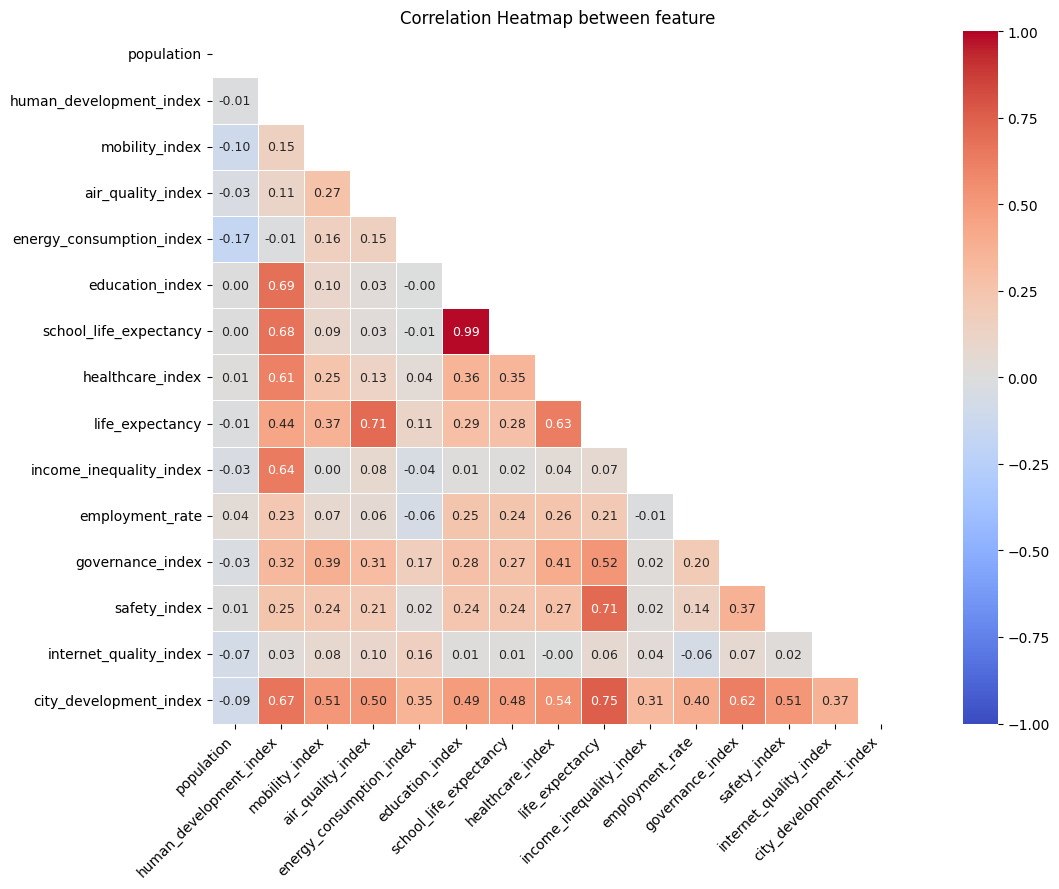

In [45]:
# Calculate the correlation matrix
correlation = df_train.drop(columns=["city_name","country_id",'year']).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(13, 9))

# Create the heatmap
sns.heatmap(correlation, 
            mask=mask, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            square=True, 
            fmt='.2f',
            annot_kws={"size": 9},
            linewidths=0.5)

# Adjust the plot
plt.title('Correlation Heatmap between feature')
plt.xticks(rotation=45, ha='right')

# Adjust layout and display
plt.tight_layout()
plt.show()

### Make `year` become ordinal data

In [48]:
df_combined['year'] = df_combined['year'].rank(method="dense").astype(np.int32)
df_combined

,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index,city_development_index,city_id
data_id,,,,,,,,,,,,,,,,,,
C1_2014,NGA,1,918263,55.93,69.44,48.15,88.33,55.74,8,70.94,56,41.11,55.64,65.10,49.82,52.02,59.63,C1
C2_2014,CIV,1,4410752,50.53,45.58,66.18,54.25,43.97,7,62.11,63,45.52,57.53,59.60,60.71,50.24,54.57,C2
C3_2014,CIV,1,822165,55.61,67.28,47.98,45.74,49.30,7,69.85,58,47.67,40.87,55.01,55.78,47.87,52.74,C3
C4_2014,BEN,1,708578,60.12,48.04,51.90,41.53,68.39,10,60.11,51,51.86,54.92,67.21,41.42,57.55,54.29,C4
C5_2014,ARE,1,1138076,76.02,75.86,61.68,67.35,82.71,12,83.28,73,62.08,74.39,71.63,74.15,52.22,70.54,C5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C996_2023,CHN,10,1254519,59.62,54.95,40.34,50.66,56.60,8,51.17,45,71.10,47.25,55.61,44.66,52.11,NaN,C996
C997_2023,CHN,10,2780142,67.28,43.82,47.36,58.30,60.48,9,58.71,53,82.64,39.68,49.06,52.46,44.03,NaN,C997
C998_2023,CHN,10,768075,53.37,49.44,27.75,64.52,51.98,8,58.04,52,50.08,61.93,50.65,69.34,47.68,NaN,C998


### Make `country_id` become categorical data

In [49]:
df_combined['country_id'] = df_combined['country_id'].astype('category')
df_combined

,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,income_inequality_index,employment_rate,governance_index,safety_index,internet_quality_index,city_development_index,city_id
data_id,,,,,,,,,,,,,,,,,,
C1_2014,NGA,1,918263,55.93,69.44,48.15,88.33,55.74,8,70.94,56,41.11,55.64,65.10,49.82,52.02,59.63,C1
C2_2014,CIV,1,4410752,50.53,45.58,66.18,54.25,43.97,7,62.11,63,45.52,57.53,59.60,60.71,50.24,54.57,C2
C3_2014,CIV,1,822165,55.61,67.28,47.98,45.74,49.30,7,69.85,58,47.67,40.87,55.01,55.78,47.87,52.74,C3
C4_2014,BEN,1,708578,60.12,48.04,51.90,41.53,68.39,10,60.11,51,51.86,54.92,67.21,41.42,57.55,54.29,C4
C5_2014,ARE,1,1138076,76.02,75.86,61.68,67.35,82.71,12,83.28,73,62.08,74.39,71.63,74.15,52.22,70.54,C5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C996_2023,CHN,10,1254519,59.62,54.95,40.34,50.66,56.60,8,51.17,45,71.10,47.25,55.61,44.66,52.11,NaN,C996
C997_2023,CHN,10,2780142,67.28,43.82,47.36,58.30,60.48,9,58.71,53,82.64,39.68,49.06,52.46,44.03,NaN,C997
C998_2023,CHN,10,768075,53.37,49.44,27.75,64.52,51.98,8,58.04,52,50.08,61.93,50.65,69.34,47.68,NaN,C998


In [50]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, C1_2014 to C1000_2023
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   country_id                9999 non-null   category
 1   year                      9999 non-null   int32   
 2   population                9999 non-null   int64   
 3   human_development_index   9999 non-null   float64 
 4   mobility_index            9999 non-null   float64 
 5   air_quality_index         9999 non-null   float64 
 6   energy_consumption_index  9999 non-null   float64 
 7   education_index           9999 non-null   float64 
 8   school_life_expectancy    9999 non-null   int64   
 9   healthcare_index          9999 non-null   float64 
 10  life_expectancy           9999 non-null   int64   
 11  income_inequality_index   9989 non-null   float64 
 12  employment_rate           9999 non-null   float64 
 13  governance_index          9999 non-null  

## Feature Selection

Upon checking the correlation, we saw that the school life expectancy and education index indicate a multicolinearity

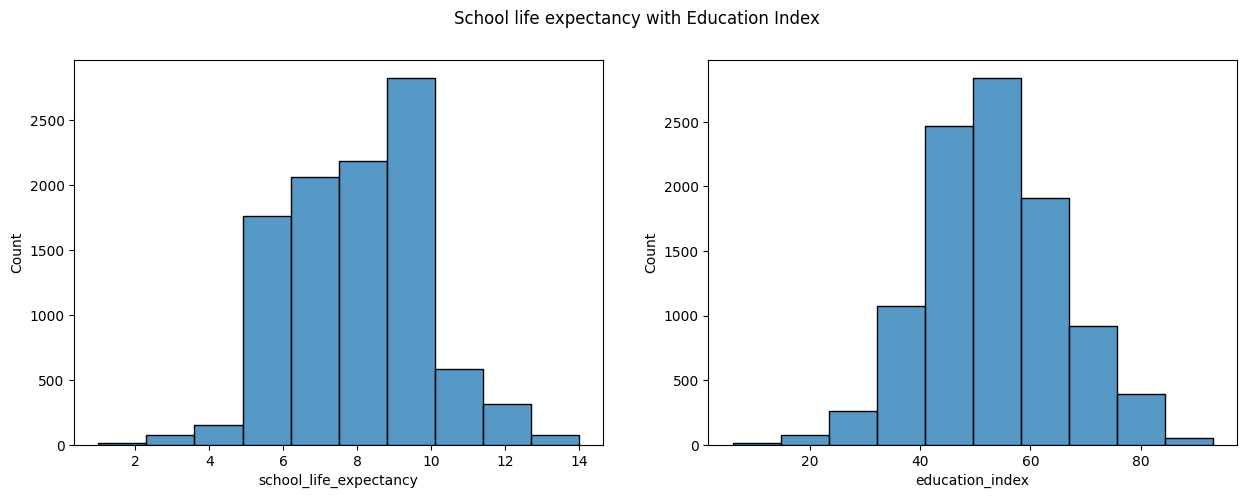

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_combined, x='school_life_expectancy', bins=10, ax=axs[0])
sns.histplot(data=df_combined, x='education_index', bins=10, ax=axs[1])
fig.suptitle("School life expectancy with Education Index")
plt.show()

#### One Hot `country_id`

In [52]:
for country in df_combined['country_id'].unique().tolist():
    df_combined[f'country_{country}'] = (df_combined['country_id'] == country)
    df_combined[f'country_{country}'] = df_combined[f'country_{country}'].astype(np.int32)
df_combined.head()


,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,...,country_SGP,country_EST,country_UZB,country_GEO,country_TUN,country_MNG,country_AUT,country_LTU,country_ARM,country_HRV
data_id,,,,,,,,,,,,,,,,,,,,,
C1_2014,NGA,1,918263,55.93,69.44,48.15,88.33,55.74,8,70.94,...,0,0,0,0,0,0,0,0,0,0
C2_2014,CIV,1,4410752,50.53,45.58,66.18,54.25,43.97,7,62.11,...,0,0,0,0,0,0,0,0,0,0
C3_2014,CIV,1,822165,55.61,67.28,47.98,45.74,49.30,7,69.85,...,0,0,0,0,0,0,0,0,0,0
C4_2014,BEN,1,708578,60.12,48.04,51.90,41.53,68.39,10,60.11,...,0,0,0,0,0,0,0,0,0,0
C5_2014,ARE,1,1138076,76.02,75.86,61.68,67.35,82.71,12,83.28,...,0,0,0,0,0,0,0,0,0,0


#### One Hot `year`

In [53]:
for year in df_combined['year'].unique().tolist():
    df_combined[f'year_{year}'] = (df_combined['year'] == year)
    df_combined[f'year_{year}'] = df_combined[f'year_{year}'].astype(np.int32)

df_combined.head()

,country_id,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,...,year_1,year_2,year_3,year_4,year_5,year_6,year_7,year_8,year_9,year_10
data_id,,,,,,,,,,,,,,,,,,,,,
C1_2014,NGA,1,918263,55.93,69.44,48.15,88.33,55.74,8,70.94,...,1,0,0,0,0,0,0,0,0,0
C2_2014,CIV,1,4410752,50.53,45.58,66.18,54.25,43.97,7,62.11,...,1,0,0,0,0,0,0,0,0,0
C3_2014,CIV,1,822165,55.61,67.28,47.98,45.74,49.30,7,69.85,...,1,0,0,0,0,0,0,0,0,0
C4_2014,BEN,1,708578,60.12,48.04,51.90,41.53,68.39,10,60.11,...,1,0,0,0,0,0,0,0,0,0
C5_2014,ARE,1,1138076,76.02,75.86,61.68,67.35,82.71,12,83.28,...,1,0,0,0,0,0,0,0,0,0


#### Drop unneeded column

In [54]:
df_combined.drop(columns=['city_id', 'country_id'], inplace=True)

In [55]:
from sklearn.preprocessing import StandardScaler

dropped_col = ['city_development_index']

scaler = StandardScaler()
df_combined_scaled = scaler.fit_transform(df_combined.drop(columns=dropped_col))
df_combined_scaled = pd.DataFrame(df_combined_scaled, columns=df_combined.drop(columns=dropped_col).columns, index=df_combined.index)

for col in dropped_col:
    df_combined_scaled[col] = df_combined[col]

df_combined = df_combined_scaled
df_combined.head()

,year,population,human_development_index,mobility_index,air_quality_index,energy_consumption_index,education_index,school_life_expectancy,healthcare_index,life_expectancy,...,year_2,year_3,year_4,year_5,year_6,year_7,year_8,year_9,year_10,city_development_index
data_id,,,,,,,,,,,,,,,,,,,,,
C1_2014,-1.57,-0.36,-0.04,2.04,0.19,3.30,0.19,-0.01,1.47,0.59,...,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,59.63
C2_2014,-1.57,0.69,-0.75,-0.38,1.71,0.30,-0.78,-0.55,0.46,1.58,...,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,54.57
C3_2014,-1.57,-0.39,-0.08,1.82,0.17,-0.45,-0.34,-0.55,1.35,0.87,...,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,52.74
C4_2014,-1.57,-0.42,0.52,-0.13,0.50,-0.83,1.23,1.08,0.23,-0.12,...,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,54.29
C5_2014,-1.57,-0.29,2.62,2.69,1.33,1.45,2.41,2.16,2.89,2.99,...,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,-0.33,70.54


In [56]:
df_train = df_combined[df_combined['city_development_index'].notnull()]
df_test = df_combined[df_combined['city_development_index'].isnull()]

In [57]:
df_train = df_train.dropna()

In [58]:
X = df_train.drop(columns=['city_development_index'], axis=1)
y = df_train['city_development_index']

In [59]:
X.shape, y.shape

((7989, 167), (7989,))

### Enumerate the best feature

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=.25)

#### Train multiple model with `lazypredict`
We do this to get the basic overview of which model are appropriate for this problem

In [61]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=mean_squared_error)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 41/42 [00:28<00:00,  1.75it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3351
[LightGBM] [Info] Number of data points in the train set: 5991, number of used features: 84
[LightGBM] [Info] Start training from score 52.607767


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:28<00:00,  1.45it/s]


In [62]:
models.sort_values('mean_squared_error').head(10)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_squared_error
Model,,,,,
Lars,1.00,1.00,0.00,0.03,0.00
BayesianRidge,1.00,1.00,0.00,0.04,0.00
LassoLarsIC,1.00,1.00,0.00,0.05,0.00
LassoLarsCV,1.00,1.00,0.00,0.15,0.00
HuberRegressor,1.00,1.00,0.00,0.20,0.00
RidgeCV,1.00,1.00,0.00,0.04,0.00
OrthogonalMatchingPursuitCV,1.00,1.00,0.00,0.06,0.00
LarsCV,1.00,1.00,0.00,0.13,0.00
OrthogonalMatchingPursuit,1.00,1.00,0.00,0.02,0.00


#### SelectKBest with top 3 model from `lazypredict`

In [80]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LassoLarsCV, Lars, BayesianRidge, LassoLarsIC

def select_k_best_features(X, y, k):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_new = selector.fit_transform(X, y)
    return X_new, selector

best_k = 0
best_score = float('inf')
accuracies= []

for k in range(1, X.shape[1] + 1):
    model_oof_pred_probs, model_r2s, model_mses = 0 , 0 , 0
    print("k:", k)
    X_new, selector = select_k_best_features(X, y, k)
    X_new = pd.DataFrame(X_new)
    selected_features = X.columns[selector.get_support(indices=True)]
    print("Selected Features:", list(selected_features))

    model =  LassoLarsIC()
    model_trainer = Trainer(model)
    model_oof_pred_probs, model_r2s, model_mses = model_trainer.fit(X_new, y)

    accuracies.append(np.mean(model_mses))
    if np.mean(model_mses) < best_score:
        best_score = np.mean(model_mses)
        best_k = k


print(f"Best number of features: {best_k}")
print(f"Best CV MSE: {best_score}")

X_best, selector = select_k_best_features(X, y, best_k)
best_features = X.columns[selector.get_support()]
print("Best features:", best_features)

k: 1
Selected Features: ['life_expectancy']
Training LassoLarsIC
--- Fold 1 - R2: 0.609851 - MSE: 12.061013
--- Fold 2 - R2: 0.539308 - MSE: 10.955183
--- Fold 3 - R2: 0.562803 - MSE: 10.312376
--- Fold 4 - R2: 0.552222 - MSE: 10.696216
--- Fold 5 - R2: 0.563590 - MSE: 11.088898
--- Fold 6 - R2: 0.546004 - MSE: 10.540079
--- Fold 7 - R2: 0.625417 - MSE: 10.012599
--- Fold 8 - R2: 0.578890 - MSE: 10.615494
--- Fold 9 - R2: 0.521098 - MSE: 10.583303
--- Fold 10 - R2: 0.578441 - MSE: 10.564549

----- MSE: 10.742971 ± 0.523232
----- R2: 0.567762 ± 0.030129


k: 2
Selected Features: ['human_development_index', 'life_expectancy']
Training LassoLarsIC
--- Fold 1 - R2: 0.765319 - MSE: 7.254906
--- Fold 2 - R2: 0.704222 - MSE: 7.033556
--- Fold 3 - R2: 0.716017 - MSE: 6.698452
--- Fold 4 - R2: 0.691244 - MSE: 7.375350
--- Fold 5 - R2: 0.708521 - MSE: 7.406300
--- Fold 6 - R2: 0.703093 - MSE: 6.893062
--- Fold 7 - R2: 0.730107 - MSE: 7.214221
--- Fold 8 - R2: 0.709952 - MSE: 7.311641
--- Fold 9 

#### Top 3 Model Select KBest Result 

```
Lars()
Best number of features: 13
Best CV MSE: 8.211641269703119e-06
Best features: Index(['human_development_index', 'mobility_index', 'air_quality_index',
       'energy_consumption_index', 'education_index', 'school_life_expectancy',
       'healthcare_index', 'life_expectancy', 'income_inequality_index',
       'employment_rate', 'governance_index', 'safety_index',
       'internet_quality_index']
```

```
BayesianRidge()
Best number of features: 13
Best CV MSE: 8.211669865925822e-06
Best features: Index(['human_development_index', 'mobility_index', 'air_quality_index',
       'energy_consumption_index', 'education_index', 'school_life_expectancy',
       'healthcare_index', 'life_expectancy', 'income_inequality_index',
       'employment_rate', 'governance_index', 'safety_index',
       'internet_quality_index'],
      dtype='object')
```

```
LassoLarsIC()
Best number of features: 13
Best CV MSE: 8.211055940212105e-06
Best features: Index(['human_development_index', 'mobility_index', 'air_quality_index',
       'energy_consumption_index', 'education_index', 'school_life_expectancy',
       'healthcare_index', 'life_expectancy', 'income_inequality_index',
       'employment_rate', 'governance_index', 'safety_index',
       'internet_quality_index'],
      dtype='object')
```

without further a do, we think that we have found the perfect feature to be used